# Radius of Non-Singularity
This code is used for calculating the radius of Non-Singularity with Quantum Logic. It follows along the Paper "Verifying Interval Matrix properties on a quantum computer" [Jan Schneider, Julian Berberich 2023].

The considered problem is given as $ d(A,\Delta)=\frac{1}{\max\{\rho_0(A^{-1}T_y \Delta T_z)|y,z \in Q_n \}} $. We can see here that the important part is the denominator, where we have to solve a binary optimization problem. For cases like this, the Quantum Approximate Optimization Algorithm is very useful and hence is used in this code. 

So we give the code a problem specific $ A^{-1} $ and since we are considering the genral case also a $ \delta $ matrix. Since the inversion of a Matrix can be done in polynomial time, it does not infect the complexity and we directly give the code an inverse. The code then calculates $ \max\{\rho_0(A^{-1}T_y \Delta T_z)|y,z \in Q_n \} $ and gives back the solution string with the highest amount of counts. In other words, that solution which resulted during the optimization the highest ammount of times as the optimum. Thanks to [laurgao](https://github.com/laurgao/qaoa-weighted-maxcut#some-interesting-insights) for the optimization structure and some important tips and hints.

Edit: We restrained conditions on $\Delta$ being a ranc(1) Matrix. This code works for $\Delta=\delta^Te$.

We start by importing all the necessary libraries.

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import minimize

In the next cell we set up our initial Problem. Since the Instance to the algorithm is a Matrix, we somehow have to incorporate this to the algorithm. A very convenient fashion of working with matrices is by transforming them into bipartite graphs. The idea behind this relies on the correlation between the maxcut quantum algorithm and our problem set up. These Graphs exist of 2 distinct subsets representing our nxn space. Hence we need n vertices per subset in order to represent a nxn Matrix. Note that it would not be necessary to do this step, it is just easier to incorporate the right edges at the right places. 

The bipartite graph representation of a matrix is then fairly simple. The $ i,j $-th matrix entry is represented by connecting node $ i $ of the first subset with node $ j$ of the second one with a weighted edge. The edge weight represents the value of the matrix entry.

What we end up with is a function to convert matrices in a bipartite graph and the setup of $ A $ and $ \delta $

In [3]:
def convert_to_bipartite(A):
    bip = nx.Graph()
    n = np.sqrt(A.size).astype(int)
    nodes_1 = list(range(0,n))
    nodes_2 = list(range(n,2*n))
    bip.add_nodes_from(nodes_1,bipartite=0)
    bip.add_nodes_from(nodes_2,bipartite=1)
    for i in range(n):
        for j in range(n,2*n):
            bip.add_edge(i,j,weight = A[i,j-n])
    
    pos = nx.bipartite_layout(bip,nodes_1)
    return bip,pos

#define Graph
#A_m2 = np.array([[1,2,3,4],[3,4,1,2],[2,3,4,1],[4,1,2,3]])
A_m2 = np.array([[1,0,1,1],[1,1,0,1],[0,1,1,1],[1,1,1,0]])
G,pos = convert_to_bipartite(A_m2)
dimension = np.sqrt(A_m2.size).astype(int) #matrix dimension

edges = list(G.edges())
weighted_edges = nx.get_edge_attributes(G, 'weight')
#print(weighted_edges)#printing the edges and the according weights (matrix entrys)

#define uncertainty
Delta = np.array([[1,1,1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4]])
G_D,pos_D = convert_to_bipartite(Delta)

edges_D = list(G_D.edges())
weighted_edges_D = nx.get_edge_attributes(G_D, 'weight')
#print(weighted_edges_D)

Next, we have to initialize the necessary things for the QAOA algorithm. QAOAs working principle is applying a problem unitary $ U(\gamma) $ and a mixing unitary $ U(\beta) $ alternating a certain ammount of times on an initial quantum state in super position. Then the expactation value is evaluated and the both variables $ \gamma $ and $ \beta $ are optimized. In every iteration, we end up with an evaluation that results in a solution string for the current optimum. This is how a solution string receives a count in the histogram.

We start of with the simulation parameters: 
* num_layers indicates how often we apply both unitaries. A low natural number is usually a good trade off between comlexity and efficiency. 
* n_qbits are double the ammount of the matrix dimension due to the problem set up.
* n_iterations defines the amount of optimization repititions. Note that this has to be choosen according to the problem dimension. For low dimensional problems, 100 iterations are sufficient. But considering for example already a 4x4 matrix, we end up with $ 2^8 $ different solutions. If we split up 100 counts on 256 solutions, it is possible that the real optimum blends in with the wrong solutions too much. However, keep in mind that more iterations increase the computational complexity.
* num_reps defines the amount of repeated algorithm iteration. Remember, that the algorithm is optimizing iteratively whil at every iteration, the algorithm is applied num_reps times

After that we construct the problem hamiltonian with the combination of $ CNOT $, $ RZ $ and $ CNOT $ as explained in the paper, depending on the individual qubits which are connected. The edge weight is then multiplied on the optimization variables. 

The mixing hamiltonian can be choosen by some beforehand given approach, which result in exploring the solution state between the layers.

The last function is used to measure the expactation value in the correct computational basis.

In [4]:
#Setup all the initial values for QAOA and the fundamental hamiltonians
num_layers = 4 #numbers of alternating mixing and problem hamiltonians
n_qbits = 2*dimension #need double the amount of qubits for algorithm
n_iterations = 100
init_params = 0.01 * np.random.rand(2, num_layers) # Initialize the parameters near zero. Generates array size 2, 4. 
num_iters = 100
num_reps =100
        
def algorithm_unitary(gamma,beta):
    #cost hamiltonian
    for edge in edges:  # pairs of nodes
        #due to the representation as bipartite, the qubits are seperated in 2 sets 
        #and the cost hamiltonian is formulated similar to the maxcut
        wire1 = edge[0]
        wire2 = edge[1]
        
        weight_A = weighted_edges[edge]
        weight_Delta = weighted_edges_D[edge] #new imposed weight from uncertainty description
        weight = weight_A*weight_Delta
        #Not that the gate we wanna use hear is a controlled Z gate (RZZ). However, 
        #qml doesnt provide this feature so we buil it on our own
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(weight*gamma, wires=wire2) #Major change to maxcut, we incorporate the weight into the optimization
        qml.CNOT(wires=[wire1, wire2])
    
    #mixing_hamiltonian
    for wire in range(n_qbits):
        qml.RX(2 * beta, wires=wire)
        
# Defining a function to measure all qubits in the computational basis, because Pennylane doesn't seem to have one.
def comp_basis_measurement(wires):
    n_qbits = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_qbits)), wires=wires)

The next cell inhibits just some necessary transition functions to switch between decimal and binary numbers and extracting binary strings out of bit strings.

In [5]:
#important functions for calculating different transformatins
def get_binary_bit_strings(bit_strings):
    bit_strings_binary = []
    for bit in bit_strings:  # Loops through each of the 100 measurements
        bit_strings_binary.append(decimal_to_binary(bit))
    return bit_strings_binary

def decimal_to_binary(decimal): # future: abstract this function to take in length.
    binary_num = []
    
    # Outputs bitstring of 1s and 0s into an array of digits
    def convert(decimal):
        if decimal >= 1:
            convert(decimal // 2)
            binary_num.append(decimal % 2)
    
    convert(decimal)
            
        
    # Change the binary number to have 4 digits, if it doesn't already
    for i in range(n_qbits + 1):
        if len(binary_num) < i:
            binary_num.insert(0, 0) # At beginning append 0
    
    return binary_num # Outputs array of the digits of the binary number

Now we construct the algorithm by concatenating all important parts, and define a function to read out the counts of the algorithm. To run the algorithm successfully, the last missing component is an appropriate cost function. The definition for the cost is also given analog to the paper.

In [6]:
#Set Up Quantum Device and Algorithm
dev = qml.device("default.qubit", wires=n_qbits, shots=1)
@qml.qnode(dev)

def circuit(gammas, betas, num_layers = 1):
    # Applies a Hadamard gate to each qubit, which puts our circuit into the quantum state |+...+>
    # In this state, the probability of measuring any computational basis state is equal. Algorithms are commonly initialized with all states in equal superposition.
    for wire in range(n_qbits):
        qml.Hadamard(wires=wire)
        
    # Repeat the cost and mixer layers p times each
    for layer in range(num_layers):
        algorithm_unitary(gammas[layer],betas[layer])
        
    # Take the measurement of all qubits in the computational basis
    measurement = qml.sample(comp_basis_measurement(range(n_qbits)))
    return measurement 

def get_counts(params):       
    # Determine the length of the params list
    params_length = len(params)

    # Calculate the number of elements in each list (gammas and betas)
    num_elements = params_length // 2

    # Use list comprehension to create gammas and betas lists
    gammas = [params[i] for i in range(0, params_length, 2)]
    betas = [params[i] for i in range(1, params_length, 2)]
    
    # The results (bit strings) of running the circuit 100 times and getting 100 measurements
    bit_strings = []
    for i in range(0, num_reps):
        hold = int(circuit(gammas, betas, num_layers=num_layers))
        bit_strings.append(hold) # This appends the integer from 0-15 (if 4 nodes) so it outputs the computational basis measurement in decimal. 

    counts = np.bincount(np.array(bit_strings)) # A 1x16 array that shows the frequency of each bitstring output
    most_freq_bit_string = np.argmax(counts) # Finds the most frequent bitstring

    return counts, bit_strings, most_freq_bit_string

def cost_function(params):
    bit_strings = get_counts(params)[1]
    binary_bit_strings = get_binary_bit_strings(bit_strings)
    total_cost = 0
    for i in range(0, len(binary_bit_strings)): # Length of binary_bit_strings should be 100
        for edge in edges:
            start_node = edge[0]
            end_node = edge[1]
            weight = weighted_edges[edge]*weighted_edges_D[edge]
            
            #this is my adaption to the cost function, see the proof for the math behind
            ron_cost = -1*weight*binary_bit_strings[i][start_node]*binary_bit_strings[i][end_node]
            
            #total_cost += ron_cost
            total_cost += ron_cost
        
    
    total_cost = float(total_cost) / 100

    print("Cost: "+str(total_cost))

    return total_cost

Last step is to run the algorithm, and print the current cost at the current iteration. This is a good indication of the performance of the algorithm. It should decrease partly and should also reach negative values. Otherwise the solution will not be good. This could have different causes like the iniitial conditions. Sometime the algorithm gets stuck in local minima which is a known problem when doing gradient descent based methods. This is why it makes sense to set random initial values for the optimization parameters, such that there is a chance to avaoid the same local minima in a second run.

In [8]:
#optimzation block
params = init_params

from scipy.optimize import minimize
out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':num_iters}) 
# This optimizer changes our initialized params from a 2x4 array into a 1x8 array

print(f'Out: {out}')

optimal_params = out['x'] # This outputs a 2x4 array not a 1x8 
optimal_params_vector = []
for layer in range(len(optimal_params[0])): # Convert the 1x8 array into a 2x4 array
    optimal_params_vector.append(optimal_params[0][layer])
    optimal_params_vector.append(optimal_params[1][layer]) # optimal_params_vector is good
    
# optimal_params_vector is an array not a tensor 
final_bitstring = get_counts(optimal_params_vector)

# The most frequent bitstring is stored in final_bitstring[2]
binary_bit_string = ''
for bit in decimal_to_binary(final_bitstring[2]): # This for loop gets the string version of the array binary bit string.
        binary_bit_string += str(bit)

print(f'Output result: {binary_bit_string}')


ValueError: 'x0' must only have one dimension.

In [8]:
# Optimization block
params = init_params

from scipy.optimize import minimize

out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter': num_iters}) 

print(f'Out: {out}')

optimal_params = out['x']
optimal_params_vector = optimal_params.reshape((2, -1))

final_bitstring = get_counts(optimal_params_vector)

# The most frequent bitstring is stored in final_bitstring[2]
binary_bit_string = ''
for bit in decimal_to_binary(final_bitstring[2]):
    binary_bit_string += str(bit)

print(f'Output result: {binary_bit_string}')

    

/var/folders/7m/mqkfpjl97fv2sybjq8l1qv3r0000gn/T/ipykernel_9600/2386872217.py:6: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter': num_iters})


Cost: -7.86
Cost: -7.7


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (256,) and arg 1 with shape (254,).

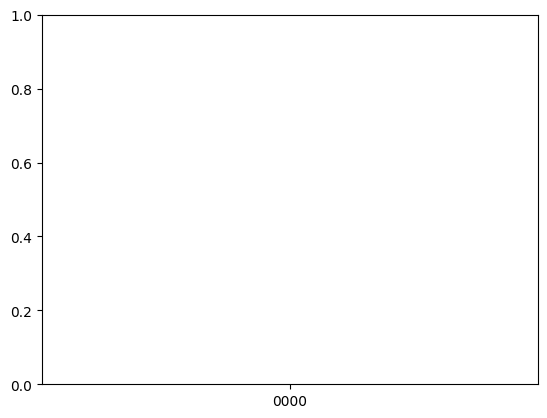

In [9]:
#plot histogram
def binary_list(n, width=None):
    #Returns a list of binary numbers up to n, with each binary number having the same width.
    binary = []
    for i in range(n+1):
        binary_number = bin(i)[2:]
        if width is not None:
            binary_number = binary_number.zfill(width)
        binary.append(binary_number)
    return binary

#print(final_bitstring[1])
#print(binary_list(15,width=4))
x_value = binary_list(255,width=4)
y_value = final_bitstring[0]
#print(y_value)
plt.bar(x_value,y_value)
plt.xticks(x_value, rotation='vertical')
plt.ylabel("Counts")
#plt.show()
plt.savefig('filename.png', dpi=300)

The Last Cell can be used to extract the 5 largest elements and corresponding indiced,
which is usefull for higher dimensional problems.

In [ ]:
import numpy as np


# Your array
array = y_value

# Find the indices that would sort the array
sorted_indices = np.argsort(array)
print(sorted_indices.size)

# Get the 5 largest elements and their indices
largest_elements = array[sorted_indices[-5:]]
largest_indices = sorted_indices[-5:]

print("5 Largest Elements:", largest_elements)
print("Corresponding Indices:", largest_indices)
